# 

# TODO

1. Generating the lattices and bases -> farm out to the HPC
2. Diagonalise and measure ringflip exp val DONE!
3. Resolve the confusion about the perturbative ring DONE!

In [1]:
import scipy.sparse.linalg as sLA
from tqdm import tqdm
import visual
from lattice import Lattice
import matplotlib.pyplot as plt
import pyrochlore


In [2]:
from ringflip_hamiltonian import RingflipHamiltonian, build_matrix, ring_exp_values



In [3]:




# visualisation methods
def show_lattice(h: RingflipHamiltonian):
        fig =plt.figure()
        ax=fig.add_axes([0,0,1,1],projection='3d')
        # visual.plot_cell(ax, h.lattice)
        visual.plot_atoms(ax, h.lattice)
        return fig, ax


def show_state(l: Lattice, state: int):
    fig =plt.figure()
    ax=fig.add_axes([0,0,1,1],projection='3d')
    # visual.plot_cell(ax, h.lattice)
    for (i, a) in enumerate(l.atoms):
        ax.scatter(*[int(x) for x in a.xyz], color='k' if state&(1<<i) else 'red')
        
    
    


In [4]:
# cellspec = [[3,0,0],[0,-3,0],[0,0,-2]]
# cellspec = [[1,-1,-1],[1,-1,1],[1,1,-1]]


# lat = pyrochlore.import_json("../lattice_files/pyro_1_3_6x-12,-4,-8b0,-4,-4b4,0,4b1.json")
lat = pyrochlore.import_json("../lattice_files/pyro_2,0,0_0,2,0_0,0,2.json")
# lat = pyrochlore.import_json("../lattice_files/pyro_1_2_2x0,4,4b4,0,4b4,4,0b1.json")
full_lat = RingflipHamiltonian(lat)
# full_lat.calc_basis(recalc=False)
full_lat.load_basis("../lattice_files/pyro_2,0,0_0,2,0_0,0,2.0.basis.csv")
# name = "%d%d%d_%d%d%d_%d%d%d" % tuple(x for x in np.ravel(cellspec))
# pyrochlore.export_json(full_lat.lattice, "../lattice_files/pyro_"+name+".json")

Loading basis...

1 sectors | line 2969
 Sorting...


In [5]:
import lattice
from sympy import Matrix
import numpy as np


def get_ringflips(lat: lattice.Lattice, sl=None, include_partial=False):
    if sl is None:
        sl = [0, 1, 2, 3]
    elif not hasattr(sl, "__iter__"):
        sl = [sl]

    retval = []

    for ix, iy, iz in lat.enumerate_primitives():
        dx = lat.primitive.lattice_vectors @ Matrix([ix, iy, iz])
        for mu in sl:
            plaq_sl_pos = pyrochlore.plaq_locs[mu]
            plaq_pos = lat.wrap_coordinate(plaq_sl_pos + dx)
            spin_members = []
            signs = []
            sign = 1
            for x in pyrochlore.plaqt[mu]:
                sign *= -1
                
                J = lat.as_linear_idx(plaq_pos + x)
                print(plaq_pos + x, J)
                if J is not None:
                    spin_members.append(J)
                    signs.append(sign)

            rr = pyrochlore.Ring(plaq_pos, mu, spin_members, signs)
            # print(spin_members)
            if include_partial:
                retval.append(rr)
            elif len(rr.members) == 6:
                retval.append(rr)

    return retval


In [6]:
xc_ops, L_ops = full_lat.build_ringops(0)

In [7]:
np.linalg.eigvals(L_ops[0].todense() - L_ops[0].T.todense())

array([0.+1.j, 0.-1.j, 0.+1.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])

In [8]:
sectors = list(full_lat.sectors)


In [8]:
# full_lat.set_ring_exchange([1,1,1,1])


def calc_spectrum(g, lat:RingflipHamiltonian):
    results = {}
    for s in full_lat.sectors:
        H = build_matrix(full_lat, g=[-1,-1,-1,-1], sector=s)
        
        if H.shape[0] < 100:
            e, v = np.linalg.eigh(H.todense())
            results[s] = (e,v)
        else:
            e, v = sLA.eigs(H,k=30,which='SR')
            results[s] = (e,v)
    return results
        

res = calc_spectrum([1,1,1,1], full_lat)


/Users/alaricsanders/.virtualenvironment/py/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/alaricsanders/.virtualenvironment/py/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


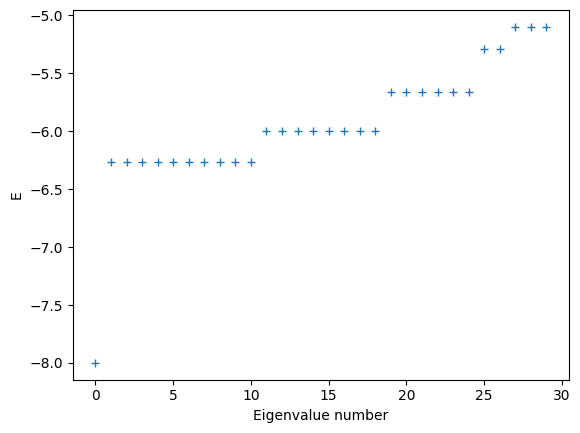

In [9]:
# plt.plot(np.real(np.sort(e1)),'kx',label='lanczos')
for s in res:
    e, v = res[s]
    plt.plot(np.sort(e)[:30],'+', label=str(s))

plt.xlabel('Eigenvalue number')
plt.ylabel("E")

# plt.plot(np.sort(res[0][0]),'ko')

# plt.legend()
exps, exps_im = ring_exp_values(full_lat, 0, res[0][1][:,:6], include_imag=True)

In [11]:
lat.bonds[0].color

0

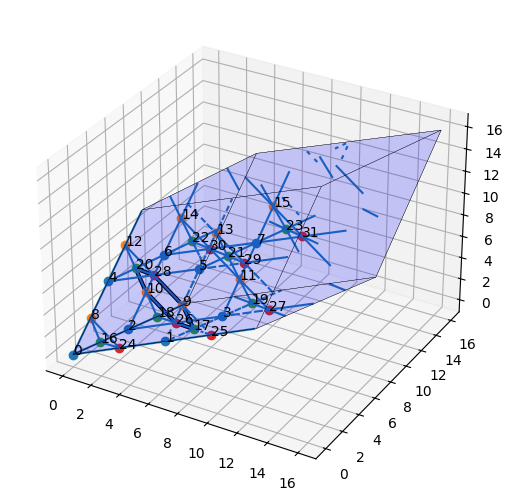

In [13]:
fig =plt.figure()
ax=fig.add_axes([0,0,1,1],projection='3d')

rf = full_lat.ringflips[0]

hexa = [full_lat.lattice.atoms[j].xyz for j in rf.members]

X = [float(hexa[-1][0])]
Y = [float(hexa[-1][1])]
Z = [float(hexa[-1][2])]

for xyz in hexa:
    X.append(float(xyz[0]))
    Y.append(float(xyz[1]))
    Z.append(float(xyz[2]))
    
ax.plot(X, Y ,Z,color='k',lw=3)
# ax.plot([0,-1],[0,-1],[0,-1],lw=3)
visual.plot_cell(ax, full_lat.lattice)


In [17]:
full_lat.lattice.atoms[0].sl_name

'0'

In [18]:

def visualise_state(ax, l:RingflipHamiltonian, state:int):
    # input->state: understood as a bitstring
    for i,a in enumerate(l.lattice.atoms):
        
        
        color='k'if (state&(1<<i)) == 0 else 'white'

        ax.plot(*a.xyz, 'o', 
                color = color,
               markeredgecolor='k' 
               )
        

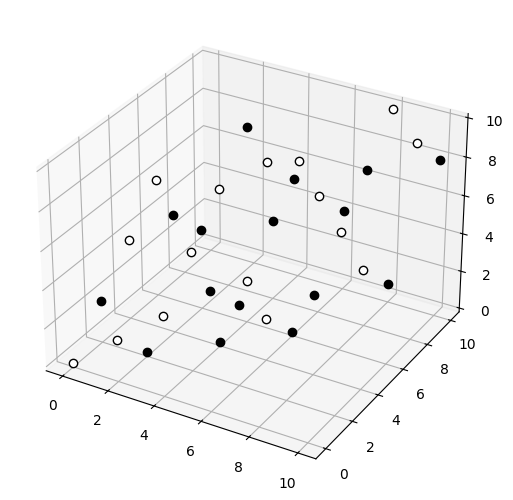

In [20]:

fig =plt.figure()
ax=fig.add_axes([0,0,1,1],projection='3d')

visualise_state(ax, full_lat, full_lat.basis[0][55])


In [ ]:
res = partition_polarisation_sectors(full_lat.basis, full_lat.lattice)

In [ ]:
res

In [ ]:
len(res[(4,4,4,4)])